In [4]:
# ========================================
# 02_unet_training.ipynb
# U-Net Model Training
# ========================================

# ----- Cell 1: Mount Google Drive -----
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# ----- Cell 2: Setup project paths -----
import os
import sys

PROJECT_ROOT = '/content/drive/MyDrive/SHBT 261/Mini_Project_2'
os.chdir(PROJECT_ROOT)

print(f"Working directory: {os.getcwd()}")
print(f"Project structure:")
!ls -lh


Working directory: /content/drive/MyDrive/SHBT 261/Mini_Project_2
Project structure:
total 1.9M
drwx------ 2 root root 4.0K Nov 15 04:09  data
-rw------- 1 root root 1.9M Nov 15 02:42 'Mini-Project 2.pdf'
drwx------ 2 root root 4.0K Nov 15 04:09  models
drwx------ 2 root root 4.0K Nov 15 04:09  notebooks
drwx------ 2 root root 4.0K Nov 15 04:09  results
-rw------- 1 root root   53 Nov 15 08:45  voc_data_path.txt


In [3]:
# ----- Cell 3: Install dependencies -----
!pip install -q segmentation-models-pytorch
!pip install -q albumentations
!pip install -q kagglehub

print("✓ Dependencies installed")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.4 MB/s eta 0:00:00
✓ Dependencies installed


In [6]:
# ----- Cell 4: Import libraries -----
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import segmentation_models_pytorch as smp

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from datetime import datetime

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [7]:
# ----- Cell 5: Load dataset path and setup data -----
import kagglehub

# Download dataset (uses cache if already downloaded)
print("Loading Pascal VOC 2007 dataset...")
dataset_path = kagglehub.dataset_download("zaraks/pascal-voc-2007")

# Find VOC root
trainval_candidates = [
    'VOCtrainval_06-Nov-2007',
    'voctrainval_06-nov-2007',
]

VOC_ROOT = None
for candidate in trainval_candidates:
    candidate_path = os.path.join(dataset_path, candidate)
    if os.path.exists(os.path.join(candidate_path, 'VOCdevkit', 'VOC2007')):
        VOC_ROOT = candidate_path
        break

print(f"✓ VOC_ROOT: {VOC_ROOT}")

# Define classes
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
    "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
    "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
NUM_CLASSES = len(VOC_CLASSES)
print(f"✓ Number of classes: {NUM_CLASSES}")


Loading Pascal VOC 2007 dataset...


100%|██████████| 1.65G/1.65G [00:09<00:00, 181MB/s]

Extracting files...


✓ VOC_ROOT: /root/.cache/kagglehub/datasets/zaraks/pascal-voc-2007/versions/1/VOCtrainval_06-Nov-2007
✓ Number of classes: 21


In [8]:
# ----- Cell 6: Data transforms with augmentation -----
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Training transforms (with augmentation)
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Validation transforms (no augmentation)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

print("✓ Data transforms defined")


✓ Data transforms defined


In [18]:
# ----- Cell 7: Custom Dataset wrapper for Albumentations -----
from torch.utils.data import Dataset
from PIL import Image

class VOCSegmentationAlbumentations(Dataset):
    """
    Wrapper for VOCSegmentation to use Albumentations transforms
    """
    def __init__(self, root, year, image_set, transform=None):
        self.voc = VOCSegmentation(
            root=root,
            year=year,
            image_set=image_set,
            download=False
        )
        self.transform = transform

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        image, mask = self.voc[idx]

        # Convert PIL to numpy
        image = np.array(image)
        mask = np.array(mask)

        # Clean mask (set boundary pixels to background)
        mask[mask == 255] = 0

        # Apply transforms
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # mask is already a tensor from ToTensorV2, just convert to long
        if not isinstance(mask, torch.Tensor):
            mask = torch.from_numpy(mask)
        mask = mask.long()

        return image, mask

print("✓ Custom dataset class defined")

✓ Custom dataset class defined


In [19]:
# ----- Cell 8: Create datasets and dataloaders -----
# Create datasets
train_dataset = VOCSegmentationAlbumentations(
    root=VOC_ROOT,
    year="2007",
    image_set="train",
    transform=train_transform
)

val_dataset = VOCSegmentationAlbumentations(
    root=VOC_ROOT,
    year="2007",
    image_set="val",
    transform=val_transform
)

# Create dataloaders
BATCH_SIZE = 8
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"✓ Train samples: {len(train_dataset)}")
print(f"✓ Val samples: {len(val_dataset)}")
print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Train batches: {len(train_loader)}")
print(f"✓ Val batches: {len(val_loader)}")


✓ Train samples: 209
✓ Val samples: 213
✓ Batch size: 8
✓ Train batches: 27
✓ Val batches: 27


In [11]:
# ----- Cell 9: Define U-Net model -----
# Create U-Net model using segmentation_models_pytorch
model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",     # Use pretrained weights
    in_channels=3,                  # RGB images
    classes=NUM_CLASSES,            # 21 classes
)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"✓ U-Net model created")
print(f"✓ Encoder: ResNet34 (pretrained on ImageNet)")
print(f"✓ Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

✓ U-Net model created
✓ Encoder: ResNet34 (pretrained on ImageNet)
✓ Device: cuda
✓ Total parameters: 24,439,269
✓ Trainable parameters: 24,439,269


In [13]:
# ----- Cell 10: Define loss function and optimizer -----
# Loss function (Cross Entropy)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam)
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5
)

print(f"✓ Loss: CrossEntropyLoss")
print(f"✓ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✓ Scheduler: ReduceLROnPlateau")

✓ Loss: CrossEntropyLoss
✓ Optimizer: Adam (lr=0.0001)
✓ Scheduler: ReduceLROnPlateau


In [14]:
# ----- Cell 11: Define metrics -----
def calculate_iou(pred, target, num_classes=21):
    """
    Calculate IoU (Intersection over Union) for each class
    """
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append((intersection / union).item())

    return ious

def calculate_pixel_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred.view(-1)
    target = target.view(-1)
    correct = (pred == target).sum().float()
    total = target.numel()
    return (correct / total).item()

print("✓ Metrics defined: IoU, Pixel Accuracy")


✓ Metrics defined: IoU, Pixel Accuracy


In [15]:
# ----- Cell 12: Training function -----
def train_epoch(model, dataloader, criterion, optimizer, device):
    """
    Train for one epoch
    """
    model.train()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate metrics
        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
        batch_acc = calculate_pixel_accuracy(preds, masks)

        # Update running metrics
        running_loss += loss.item()
        running_iou.append(batch_iou)
        running_acc += batch_acc

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{batch_acc:.4f}'
        })

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = np.nanmean(running_iou)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_iou, epoch_acc

print("✓ Training function defined")


✓ Training function defined


In [16]:
# ----- Cell 13: Validation function -----
def validate(model, dataloader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    running_iou = []
    running_acc = 0.0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Calculate metrics
            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks, NUM_CLASSES)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            # Update running metrics
            running_loss += loss.item()
            running_iou.append(batch_iou)
            running_acc += batch_acc

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{batch_acc:.4f}'
            })

    # Calculate epoch metrics
    epoch_loss = running_loss / len(dataloader)
    epoch_iou = np.nanmean(running_iou)
    epoch_acc = running_acc / len(dataloader)

    return epoch_loss, epoch_iou, epoch_acc

print("✓ Validation function defined")


✓ Validation function defined


In [20]:
# ----- Cell 14: Training loop -----
NUM_EPOCHS = 30

# Initialize tracking
best_val_iou = 0.0
history = {
    'train_loss': [],
    'train_iou': [],
    'train_acc': [],
    'val_loss': [],
    'val_iou': [],
    'val_acc': [],
}

# Create models directory
os.makedirs(f'{PROJECT_ROOT}/models', exist_ok=True)

print("=" * 70)
print(f"Starting U-Net Training")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")
print("=" * 70)

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_iou, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validate
    val_loss, val_iou, val_acc = validate(
        model, val_loader, criterion, device
    )

    # Update scheduler
    scheduler.step(val_loss)

    # Save metrics
    history['train_loss'].append(train_loss)
    history['train_iou'].append(train_iou)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_acc'].append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val IoU:   {val_iou:.4f} | Val Acc:   {val_acc:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'val_loss': val_loss,
        }, f'{PROJECT_ROOT}/models/unet_best.pth')
        print(f"  ✓ Best model saved! (IoU: {val_iou:.4f})")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f'{PROJECT_ROOT}/models/unet_checkpoint_epoch_{epoch+1}.pth')
        print(f"  ✓ Checkpoint saved at epoch {epoch+1}")

# Training complete
end_time = time.time()
training_time = end_time - start_time

print("\n" + "=" * 70)
print("TRAINING COMPLETE!")
print("=" * 70)
print(f"Total training time: {training_time/60:.2f} minutes")
print(f"Best validation IoU: {best_val_iou:.4f}")
print(f"Models saved to: {PROJECT_ROOT}/models/")


Starting U-Net Training
Epochs: 30
Device: cuda

Epoch 1/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.73it/s, loss=2.7001, acc=0.1410]



Epoch 1 Summary:
  Train Loss: 2.9627 | Train IoU: 0.0171 | Train Acc: 0.1006
  Val Loss:   2.7473 | Val IoU:   0.0269 | Val Acc:   0.1804
  ✓ Best model saved! (IoU: 0.0269)

Epoch 2/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.75it/s, loss=2.3607, acc=0.4447]



Epoch 2 Summary:
  Train Loss: 2.5523 | Train IoU: 0.0463 | Train Acc: 0.3322
  Val Loss:   2.3721 | Val IoU:   0.0532 | Val Acc:   0.4466
  ✓ Best model saved! (IoU: 0.0532)

Epoch 3/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 16.47it/s, loss=2.1433, acc=0.6692]



Epoch 3 Summary:
  Train Loss: 2.2643 | Train IoU: 0.0674 | Train Acc: 0.5839
  Val Loss:   2.1629 | Val IoU:   0.0658 | Val Acc:   0.6276
  ✓ Best model saved! (IoU: 0.0658)

Epoch 4/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.60it/s, loss=1.9472, acc=0.7228]



Epoch 4 Summary:
  Train Loss: 1.9959 | Train IoU: 0.0791 | Train Acc: 0.6975
  Val Loss:   1.9181 | Val IoU:   0.0705 | Val Acc:   0.6961
  ✓ Best model saved! (IoU: 0.0705)

Epoch 5/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.96it/s, loss=1.7808, acc=0.6944]



Epoch 5 Summary:
  Train Loss: 1.7686 | Train IoU: 0.0811 | Train Acc: 0.7346
  Val Loss:   1.6982 | Val IoU:   0.0791 | Val Acc:   0.7424
  ✓ Best model saved! (IoU: 0.0791)

Epoch 6/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.87it/s, loss=1.5502, acc=0.7553]



Epoch 6 Summary:
  Train Loss: 1.5502 | Train IoU: 0.0846 | Train Acc: 0.7632
  Val Loss:   1.5029 | Val IoU:   0.0884 | Val Acc:   0.7721
  ✓ Best model saved! (IoU: 0.0884)

Epoch 7/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 16.78it/s, loss=1.3879, acc=0.7492]



Epoch 7 Summary:
  Train Loss: 1.3983 | Train IoU: 0.0896 | Train Acc: 0.7650
  Val Loss:   1.3282 | Val IoU:   0.0813 | Val Acc:   0.7710

Epoch 8/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.23it/s, loss=1.2956, acc=0.7598]



Epoch 8 Summary:
  Train Loss: 1.2144 | Train IoU: 0.0944 | Train Acc: 0.7970
  Val Loss:   1.2219 | Val IoU:   0.0904 | Val Acc:   0.7899
  ✓ Best model saved! (IoU: 0.0904)

Epoch 9/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.71it/s, loss=1.1094, acc=0.7644]



Epoch 9 Summary:
  Train Loss: 1.1063 | Train IoU: 0.0983 | Train Acc: 0.8005
  Val Loss:   1.0834 | Val IoU:   0.0942 | Val Acc:   0.7930
  ✓ Best model saved! (IoU: 0.0942)

Epoch 10/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.57it/s, loss=1.1857, acc=0.7370]



Epoch 10 Summary:
  Train Loss: 1.0152 | Train IoU: 0.0969 | Train Acc: 0.8071
  Val Loss:   1.1383 | Val IoU:   0.0976 | Val Acc:   0.7735
  ✓ Best model saved! (IoU: 0.0976)
  ✓ Checkpoint saved at epoch 10

Epoch 11/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.03it/s, loss=0.9888, acc=0.7842]



Epoch 11 Summary:
  Train Loss: 0.9304 | Train IoU: 0.1146 | Train Acc: 0.8151
  Val Loss:   0.9913 | Val IoU:   0.1159 | Val Acc:   0.8081
  ✓ Best model saved! (IoU: 0.1159)

Epoch 12/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.90it/s, loss=0.9169, acc=0.7644]



Epoch 12 Summary:
  Train Loss: 0.9002 | Train IoU: 0.1208 | Train Acc: 0.8116
  Val Loss:   0.9152 | Val IoU:   0.1290 | Val Acc:   0.8136
  ✓ Best model saved! (IoU: 0.1290)

Epoch 13/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.17it/s, loss=0.9097, acc=0.7707]



Epoch 13 Summary:
  Train Loss: 0.8399 | Train IoU: 0.1236 | Train Acc: 0.8166
  Val Loss:   0.9180 | Val IoU:   0.1130 | Val Acc:   0.7961

Epoch 14/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.05it/s, loss=1.0214, acc=0.7457]



Epoch 14 Summary:
  Train Loss: 0.7906 | Train IoU: 0.1240 | Train Acc: 0.8243
  Val Loss:   0.9094 | Val IoU:   0.1163 | Val Acc:   0.8058

Epoch 15/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.60it/s, loss=0.9526, acc=0.7606]



Epoch 15 Summary:
  Train Loss: 0.7679 | Train IoU: 0.1294 | Train Acc: 0.8210
  Val Loss:   0.8384 | Val IoU:   0.1375 | Val Acc:   0.8126
  ✓ Best model saved! (IoU: 0.1375)

Epoch 16/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.88it/s, loss=0.9109, acc=0.7584]



Epoch 16 Summary:
  Train Loss: 0.7103 | Train IoU: 0.1510 | Train Acc: 0.8345
  Val Loss:   0.8238 | Val IoU:   0.1325 | Val Acc:   0.8123

Epoch 17/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.81it/s, loss=0.9613, acc=0.7582]



Epoch 17 Summary:
  Train Loss: 0.6788 | Train IoU: 0.1524 | Train Acc: 0.8352
  Val Loss:   0.7984 | Val IoU:   0.1407 | Val Acc:   0.8156
  ✓ Best model saved! (IoU: 0.1407)

Epoch 18/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.10it/s, loss=0.8634, acc=0.7571]



Epoch 18 Summary:
  Train Loss: 0.6707 | Train IoU: 0.1506 | Train Acc: 0.8293
  Val Loss:   0.7930 | Val IoU:   0.1404 | Val Acc:   0.8149

Epoch 19/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 16.30it/s, loss=0.8861, acc=0.7560]



Epoch 19 Summary:
  Train Loss: 0.6354 | Train IoU: 0.1613 | Train Acc: 0.8367
  Val Loss:   0.8035 | Val IoU:   0.1373 | Val Acc:   0.8144

Epoch 20/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.50it/s, loss=0.7990, acc=0.7387]



Epoch 20 Summary:
  Train Loss: 0.6279 | Train IoU: 0.1515 | Train Acc: 0.8348
  Val Loss:   0.8429 | Val IoU:   0.1337 | Val Acc:   0.7978
  ✓ Checkpoint saved at epoch 20

Epoch 21/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 16.65it/s, loss=0.8927, acc=0.7614]



Epoch 21 Summary:
  Train Loss: 0.6647 | Train IoU: 0.1607 | Train Acc: 0.8300
  Val Loss:   0.7689 | Val IoU:   0.1435 | Val Acc:   0.8161
  ✓ Best model saved! (IoU: 0.1435)

Epoch 22/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 15.62it/s, loss=0.8887, acc=0.7544]



Epoch 22 Summary:
  Train Loss: 0.5961 | Train IoU: 0.1557 | Train Acc: 0.8398
  Val Loss:   0.8014 | Val IoU:   0.1485 | Val Acc:   0.8158
  ✓ Best model saved! (IoU: 0.1485)

Epoch 23/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.21it/s, loss=0.8713, acc=0.7609]



Epoch 23 Summary:
  Train Loss: 0.5672 | Train IoU: 0.1861 | Train Acc: 0.8456
  Val Loss:   0.7703 | Val IoU:   0.1474 | Val Acc:   0.8159

Epoch 24/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.01it/s, loss=0.8274, acc=0.7591]



Epoch 24 Summary:
  Train Loss: 0.5600 | Train IoU: 0.1743 | Train Acc: 0.8478
  Val Loss:   0.7441 | Val IoU:   0.1575 | Val Acc:   0.8230
  ✓ Best model saved! (IoU: 0.1575)

Epoch 25/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 12.72it/s, loss=0.9729, acc=0.7654]



Epoch 25 Summary:
  Train Loss: 0.6578 | Train IoU: 0.1899 | Train Acc: 0.8325
  Val Loss:   0.7692 | Val IoU:   0.1532 | Val Acc:   0.8209

Epoch 26/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 13.84it/s, loss=0.9224, acc=0.7640]



Epoch 26 Summary:
  Train Loss: 0.5309 | Train IoU: 0.2084 | Train Acc: 0.8589
  Val Loss:   0.7557 | Val IoU:   0.1589 | Val Acc:   0.8197
  ✓ Best model saved! (IoU: 0.1589)

Epoch 27/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 17.99it/s, loss=0.9740, acc=0.7645]



Epoch 27 Summary:
  Train Loss: 0.5772 | Train IoU: 0.2026 | Train Acc: 0.8501
  Val Loss:   0.7300 | Val IoU:   0.1642 | Val Acc:   0.8250
  ✓ Best model saved! (IoU: 0.1642)

Epoch 28/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 18.46it/s, loss=0.8227, acc=0.7204]



Epoch 28 Summary:
  Train Loss: 0.5182 | Train IoU: 0.2166 | Train Acc: 0.8631
  Val Loss:   0.7619 | Val IoU:   0.1574 | Val Acc:   0.8196

Epoch 29/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.20it/s, loss=0.8816, acc=0.7379]



Epoch 29 Summary:
  Train Loss: 0.5548 | Train IoU: 0.2239 | Train Acc: 0.8561
  Val Loss:   0.7555 | Val IoU:   0.1497 | Val Acc:   0.8198

Epoch 30/30
----------------------------------------------------------------------


Validation: 100%|██████████| 27/27 [00:01<00:00, 14.91it/s, loss=0.9126, acc=0.7581]



Epoch 30 Summary:
  Train Loss: 0.5034 | Train IoU: 0.2252 | Train Acc: 0.8701
  Val Loss:   0.7714 | Val IoU:   0.1727 | Val Acc:   0.8213
  ✓ Best model saved! (IoU: 0.1727)
  ✓ Checkpoint saved at epoch 30

TRAINING COMPLETE!
Total training time: 3.59 minutes
Best validation IoU: 0.1727
Models saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/


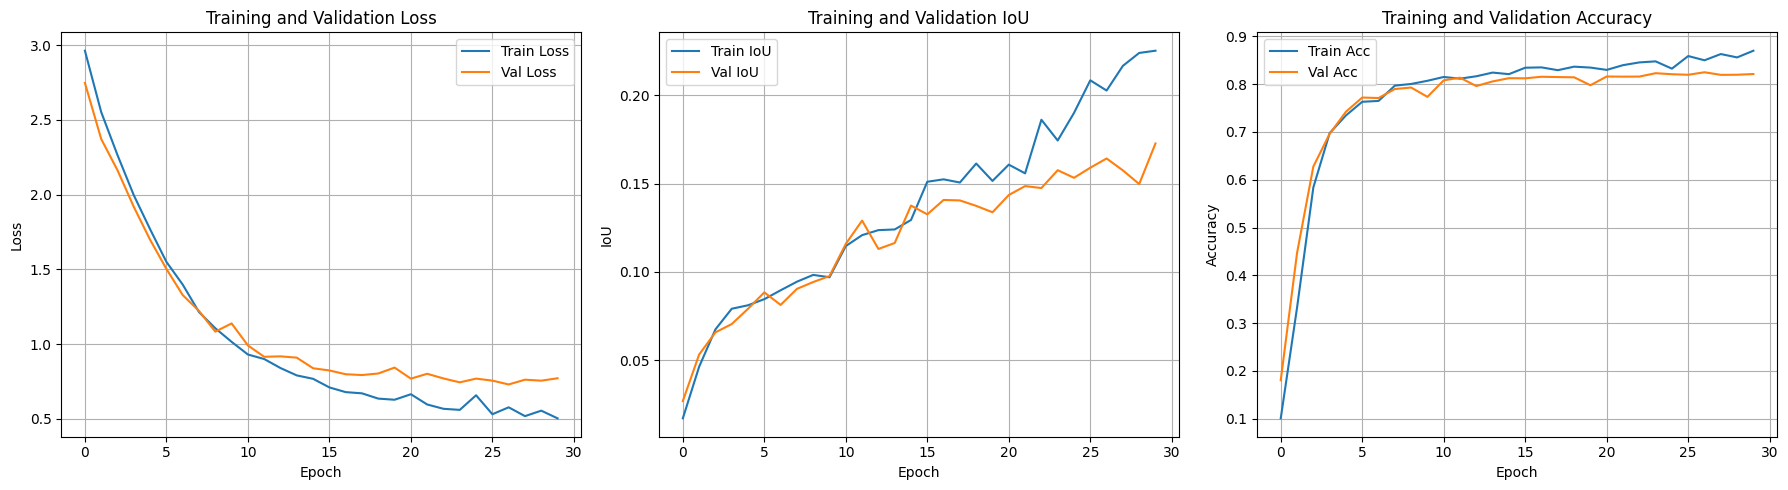

✓ Training history saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/unet_training_history.png
✓ Final model saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/unet_final.pth

✓ U-Net training complete!

Next: Create 03_deeplabv3_training.ipynb for DeepLabV3+ model


In [21]:
# ----- Cell 15: Plot training history -----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot IoU
axes[1].plot(history['train_iou'], label='Train IoU')
axes[1].plot(history['val_iou'], label='Val IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title('Training and Validation IoU')
axes[1].legend()
axes[1].grid(True)

# Plot Accuracy
axes[2].plot(history['train_acc'], label='Train Acc')
axes[2].plot(history['val_acc'], label='Val Acc')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training and Validation Accuracy')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(f'{PROJECT_ROOT}/results/unet_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Training history saved to: {PROJECT_ROOT}/results/unet_training_history.png")


# ----- Cell 16: Save final model and history -----
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'best_val_iou': best_val_iou,
    'training_time': training_time,
}, f'{PROJECT_ROOT}/models/unet_final.pth')

print(f"✓ Final model saved to: {PROJECT_ROOT}/models/unet_final.pth")
print("\n✓ U-Net training complete!")
print("\nNext: Create 03_deeplabv3_training.ipynb for DeepLabV3+ model")


In [23]:
# ----- Cell 17: Load best model for inference -----
# Load the best saved model
checkpoint = torch.load(f'{PROJECT_ROOT}/models/unet_best.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Best model loaded (from epoch {checkpoint['epoch']+1})")
print(f"  Validation IoU: {checkpoint['val_iou']:.4f}")
print(f"  Validation Loss: {checkpoint['val_loss']:.4f}")

✓ Best model loaded (from epoch 30)
  Validation IoU: 0.1727
  Validation Loss: 0.7714


In [24]:
# ----- Cell 18: Visualize predictions -----
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataset, device, num_samples=5, save_dir=None):
    """
    Visualize model predictions on sample images
    """
    model.eval()

    # Create save directory if needed
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for i in range(num_samples):
            # Get random sample
            idx = np.random.randint(0, len(dataset))
            image, mask = dataset[idx]

            # Prepare for model
            image_input = image.unsqueeze(0).to(device)

            # Predict
            output = model(image_input)
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

            # Denormalize image for display
            img_display = image.cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = std * img_display + mean
            img_display = np.clip(img_display, 0, 1)

            # Get ground truth mask
            mask_gt = mask.cpu().numpy()

            # Plot original image
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            # Plot ground truth
            axes[i, 1].imshow(mask_gt, cmap='tab20', vmin=0, vmax=20)
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            # Plot prediction
            axes[i, 2].imshow(pred, cmap='tab20', vmin=0, vmax=20)
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()

    if save_dir:
        save_path = os.path.join(save_dir, 'unet_predictions.png')
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"✓ Predictions saved to: {save_path}")

    plt.show()

# Visualize on validation set
print("Visualizing predictions on validation set...")
visualize_predictions(
    model,
    val_dataset,
    device,
    num_samples=5,
    save_dir=f'{PROJECT_ROOT}/results'
)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# ----- Cell 19: Calculate final metrics on validation set -----
def evaluate_model(model, dataloader, device, num_classes=21):
    """
    Comprehensive evaluation on validation set
    """
    model.eval()

    all_ious = []
    all_accs = []
    class_ious = [[] for _ in range(num_classes)]

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc='Evaluating'):
            images = images.to(device)
            masks = masks.to(device)

            # Predict
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            # Calculate metrics
            batch_iou = calculate_iou(preds, masks, num_classes)
            batch_acc = calculate_pixel_accuracy(preds, masks)

            all_ious.append(batch_iou)
            all_accs.append(batch_acc)

            # Per-class IoU
            for cls in range(num_classes):
                if not np.isnan(batch_iou[cls]):
                    class_ious[cls].append(batch_iou[cls])

    # Calculate mean metrics
    mean_iou = np.nanmean(all_ious)
    mean_acc = np.mean(all_accs)

    # Per-class mean IoU
    per_class_iou = [np.mean(ious) if len(ious) > 0 else 0.0 for ious in class_ious]

    return mean_iou, mean_acc, per_class_iou

print("Evaluating U-Net on validation set...")
val_iou, val_acc, per_class_iou = evaluate_model(model, val_loader, device)

print("\n" + "=" * 70)
print("FINAL VALIDATION METRICS")
print("=" * 70)
print(f"Mean IoU: {val_iou:.4f}")
print(f"Pixel Accuracy: {val_acc:.4f}")
print("\nPer-class IoU:")
print("-" * 70)
for idx, iou in enumerate(per_class_iou):
    print(f"  {idx:2d}. {VOC_CLASSES[idx]:15s}: {iou:.4f}")
print("=" * 70)

Evaluating U-Net on validation set...


Evaluating: 100%|██████████| 27/27 [00:01<00:00, 18.15it/s]


FINAL VALIDATION METRICS
Mean IoU: 0.1727
Pixel Accuracy: 0.8213

Per-class IoU:
----------------------------------------------------------------------
   0. background     : 0.8344
   1. aeroplane      : 0.0000
   2. bicycle        : 0.0000
   3. bird           : 0.1373
   4. boat           : 0.0000
   5. bottle         : 0.0000
   6. bus            : 0.2240
   7. car            : 0.0000
   8. cat            : 0.2185
   9. chair          : 0.0000
  10. cow            : 0.0009
  11. diningtable    : 0.0001
  12. dog            : 0.2016
  13. horse          : 0.0556
  14. motorbike      : 0.1269
  15. person         : 0.5113
  16. pottedplant    : 0.0000
  17. sheep          : 0.0000
  18. sofa           : 0.0352
  19. train          : 0.1600
  20. tvmonitor      : 0.0783


In [26]:
# ----- Cell 20: Save training summary -----
import json

# Create summary dictionary
summary = {
    'model': 'U-Net',
    'encoder': 'ResNet34',
    'pretrained': True,
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'optimizer': 'Adam',
    'loss_function': 'CrossEntropyLoss',
    'training_time_minutes': training_time / 60,
    'best_val_iou': float(best_val_iou),
    'final_val_iou': float(val_iou),
    'final_val_acc': float(val_acc),
    'num_parameters': trainable_params,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
}

# Save to JSON
summary_path = f'{PROJECT_ROOT}/results/unet_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=4)

print("=" * 70)
print("U-NET TRAINING SUMMARY")
print("=" * 70)
for key, value in summary.items():
    print(f"{key:25s}: {value}")
print("=" * 70)
print(f"\n✓ Summary saved to: {summary_path}")

U-NET TRAINING SUMMARY
model                    : U-Net
encoder                  : ResNet34
pretrained               : True
num_epochs               : 30
batch_size               : 8
learning_rate            : 0.0001
optimizer                : Adam
loss_function            : CrossEntropyLoss
training_time_minutes    : 3.5927712082862855
best_val_iou             : 0.17266717326019618
final_val_iou            : 0.17266717326019618
final_val_acc            : 0.8212796537964432
num_parameters           : 24439269
train_samples            : 209
val_samples              : 213

✓ Summary saved to: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/unet_summary.json


In [27]:
# ----- Cell 21: Final notes and next steps -----
print("=" * 70)
print("U-NET TRAINING COMPLETE!")
print("=" * 70)
print("\nFiles saved:")
print(f"  1. Best model: {PROJECT_ROOT}/models/unet_best.pth")
print(f"  2. Final model: {PROJECT_ROOT}/models/unet_final.pth")
print(f"  3. Training history plot: {PROJECT_ROOT}/results/unet_training_history.png")
print(f"  4. Predictions: {PROJECT_ROOT}/results/unet_predictions.png")
print(f"  5. Summary: {PROJECT_ROOT}/results/unet_summary.json")

print("\n" + "=" * 70)
print("NEXT STEPS")
print("=" * 70)
print("1. ✓ U-Net training completed")
print("2. → Create 03_deeplabv3_training.ipynb")
print("3. → Create 04_sam_training.ipynb (or another model)")
print("4. → Create 05_evaluation.ipynb to compare all models")
print("=" * 70)

print("\n✓ You can now disconnect and the results are saved to Drive!")

U-NET TRAINING COMPLETE!

Files saved:
  1. Best model: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/unet_best.pth
  2. Final model: /content/drive/MyDrive/SHBT 261/Mini_Project_2/models/unet_final.pth
  3. Training history plot: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/unet_training_history.png
  4. Predictions: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/unet_predictions.png
  5. Summary: /content/drive/MyDrive/SHBT 261/Mini_Project_2/results/unet_summary.json

NEXT STEPS
1. ✓ U-Net training completed
2. → Create 03_deeplabv3_training.ipynb
3. → Create 04_sam_training.ipynb (or another model)
4. → Create 05_evaluation.ipynb to compare all models

✓ You can now disconnect and the results are saved to Drive!
